# Task 1 - Linear regression with scikit-learn
## Subtasks
Load the datasets from the previous lab. This time you are going to perform the linear regression using
the library scikit-learn.
- Obtain the regression coefficients.
- Once again predict for the following values (35, 80)
- Finally obtain the MSE value
- Compare the results with the ones obtained in the previous lab.
- Are there any differences?

In [291]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [292]:
income_data = pd.read_csv('datasets/income_data.csv', encoding='unicode_escape')
income_data.head()

,region,age,2020
0,01 Stockholm county,16 years,4.6
1,01 Stockholm county,17 years,8.8
2,01 Stockholm county,18 years,17.8
3,01 Stockholm county,19 years,52.5
4,01 Stockholm county,20 years,112.0


In [293]:
linear_regressor = LinearRegression()
mean_income_by_region_per_age_group = income_data.groupby('age')[['region', '2020']].mean(numeric_only=True).reset_index()
ages = mean_income_by_region_per_age_group.age
ages_numeric = pd.to_numeric(ages.str.strip('+ years'))
mean_incomes_2020 = mean_income_by_region_per_age_group['2020']

linear_regressor.fit(ages_numeric.to_frame(), mean_incomes_2020)

LinearRegression()

The regression coefficients:

In [294]:
print(linear_regressor.coef_)
linear_regressor.intercept_

[-0.40557442]


301.9047166773686

The first value above is the slope, while the second one is where the regression line intercepts the y-axis.

Now let's predict the income for ages 35 and 80.

In [295]:
ages_to_predict = np.array([35, 80]).reshape(-1, 1)
linear_regressor.predict(ages_to_predict)

/Users/paripasviktor/ltu/pml/venv/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([287.70961212, 269.45876341])

Now let's check the mean squared error:

In [296]:
predicted_mean_incomes_2020 = linear_regressor.predict(ages_numeric.to_frame())
mean_squared_error(mean_incomes_2020, predicted_mean_incomes_2020)

9974.38982192875

The results are the same as the ones calculated in lab 2. (Those results were already validated against the scikit-learn linear regression results.)
Finally, let's plot the results:

/Users/paripasviktor/ltu/pml/venv/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


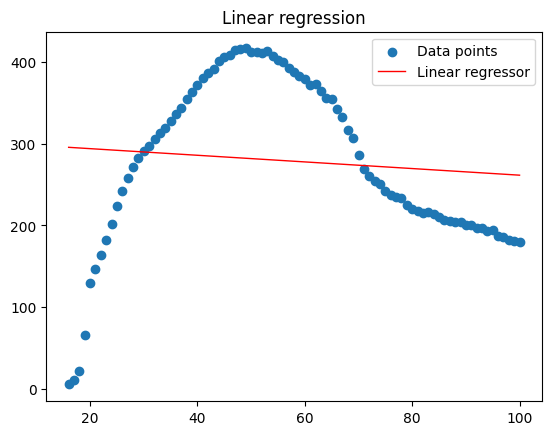

In [297]:
plt.figure()
plt.scatter(ages_numeric.to_frame(), mean_incomes_2020)
ages_sequence = np.linspace(ages_numeric.to_frame().min(), ages_numeric.to_frame().max(), 300)
plt.plot(ages_sequence, linear_regressor.predict(ages_sequence), color='red', linewidth=1)
plt.title('Linear regression')
plt.legend(['Data points', 'Linear regressor'])
plt.show()

# Polynomial regression with hyperparameter optimization
Linear regression result may not be the optimal result as shown by the MSE value.
You will now use Scikit-learn to perform polynomial regression and evaluate if it is a better model.
## Perform polynomial regression
Polynomial regression is a special case of linear regression.
With the use of PolynomialFeatures from sklearn.preprocessing you will be able to increase the
number of features the linear regression model is trained.
- For additional information on how to perform this task check lecture 8 and page 128 of
the ML book.
## Optimizing the degree of the polynomial
You may notice there is a Hyperparameter for this model, which is the polynomial degree,
you will not need to find the optimal degree of this polynomial using Gridsearch.
- For this task you will need to implement Gridsearch from scratch, you will be able to use
scikit-learn for fitting the data, but you will manually iterate over a set of degrees and
find the cross-validation score for each degree to find the optimal degree value.
- Which order of the polynomial is best?
## Plotting
Graph the results of the polynomial regression line with the optimal degree found along
with the linear regression line.

## Performing polynomial regression
Since the data seems to show an inflexion point around age 70, let's start with a 3rd-degree polynomial.

In [298]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures


def make_polynomial_regression_pipeline(degree=None):
    if degree is not None:
        return make_pipeline(PolynomialFeatures(degree), LinearRegression())
    else:  # use the default degree for polynomial regression
        return make_pipeline(PolynomialFeatures(), LinearRegression())

degree = 3
polynomial_regression = make_polynomial_regression_pipeline(degree=degree)
polynomial_regression.fit(ages_numeric.to_frame(), mean_incomes_2020)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('linearregression', LinearRegression())])

/Users/paripasviktor/ltu/pml/venv/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/paripasviktor/ltu/pml/venv/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


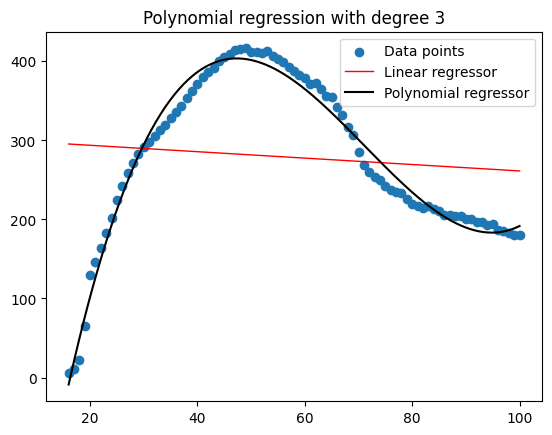

In [299]:
plt.scatter(ages_numeric.to_frame(), mean_incomes_2020)
plt.plot(ages_sequence, linear_regressor.predict(ages_sequence), color='red', linewidth=1)
plt.plot(ages_sequence, polynomial_regression.predict(ages_sequence), color='black')
plt.title(f'Polynomial regression with degree {degree}')
plt.legend(['Data points', 'Linear regressor', 'Polynomial regressor'])
plt.show()

We can already see that the polynomial regression fits our data better, but let's check the MSE score regardless.

In [300]:
predicted_mean_incomes_2020 = polynomial_regression.predict(ages_numeric.to_frame())
mean_squared_error(mean_incomes_2020, predicted_mean_incomes_2020)

210.57459967927306

As we expected, the mean squared error is much less by about two magnitudes!
Now let's find out which hyperparameter works best for the regressor.
## Hyperparameter optimization
First encapsulate what we already calculated (the mean squared error) as a cost function

In [301]:
def mse_cost_function_for_polynomial_regression(degree):
    polynomial_regression = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    polynomial_regression.fit(ages_numeric.to_frame(), mean_incomes_2020)
    predicted_mean_incomes_2020 = polynomial_regression.predict(ages_numeric.to_frame())
    mse = mean_squared_error(mean_incomes_2020, predicted_mean_incomes_2020)
    return mse

Now we can implement the grid search to find the polynomial degree (our hyperparameter) that results in the fit with the lowest MSE.

In [302]:
import itertools


def simple_grid_search(cost_function, hyperparameter_ranges):
    hyperparameter_names = hyperparameter_ranges.keys()
    hyperparameter_ranges_array = hyperparameter_ranges.values()

    all_steps = [
        {param_name:param_value for param_name, param_value in zip(hyperparameter_names, grid_point)}
        for grid_point in itertools.product(*hyperparameter_ranges_array)
    ]
    grid_results = [cost_function(**step) for step in all_steps]
    best_index = np.argmin(grid_results)
    return all_steps[best_index], grid_results[best_index]


Now we can run the grid search to find the most optimal fit.

In [303]:
DEGREES_TO_SEARCH = np.arange(1, 16)
best_parameters, best_mse = simple_grid_search(
    mse_cost_function_for_polynomial_regression, {'degree' : DEGREES_TO_SEARCH}
)
best_degree = best_parameters['degree']
print(f"The lowest MSE ({best_mse:.2f}) was found for degree = {best_degree}")


The lowest MSE (53.36) was found for degree = 8


We can see that the lowest MSE was found for an 8th-degree polynomial, let's plot the results as well:

/Users/paripasviktor/ltu/pml/venv/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/paripasviktor/ltu/pml/venv/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/Users/paripasviktor/ltu/pml/venv/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


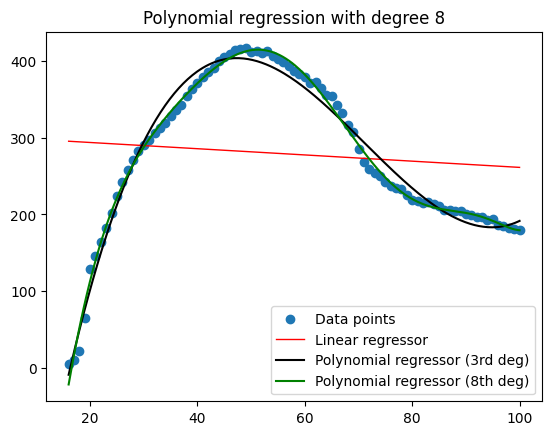

In [304]:
new_polynomial_regression = make_polynomial_regression_pipeline(degree=best_degree)
new_polynomial_regression.fit(ages_numeric.to_frame(), mean_incomes_2020)
plt.figure()
plt.scatter(ages_numeric.to_frame(), mean_incomes_2020)
plt.plot(ages_sequence, linear_regressor.predict(ages_sequence), color='red', linewidth=1)
plt.plot(ages_sequence, polynomial_regression.predict(ages_sequence), color='black')
plt.plot(ages_sequence, new_polynomial_regression.predict(ages_sequence), color='green')
plt.title(f'Polynomial regression with degree {best_degree}')
plt.legend(['Data points', 'Linear regressor', 'Polynomial regressor (3rd deg)', 'Polynomial regressor (8th deg)'])
plt.show()

Indeed the 8th-degree polynomial is a near-perfect fit on the (training) data, but for good measure run scikit-learn's grid search to confirm that that is the case.

In [305]:
from sklearn.model_selection import GridSearchCV


pr_pipeline = make_polynomial_regression_pipeline()
parameter_grid = {
    'polynomialfeatures__degree': DEGREES_TO_SEARCH,
}
grid_search = GridSearchCV(pr_pipeline, parameter_grid, scoring='neg_mean_squared_error')
grid_search.fit(ages_numeric.to_frame(), mean_incomes_2020)
print(-grid_search.best_score_)
grid_search.best_params_

2606.5382632846627


{'polynomialfeatures__degree': 3}

Scikit-learn's optimal solution differs from ours, but why? The answer is that our grid search was evaluated on the training data which made it biased towards higher-degree polynomials which can obviously fit the training data better but will not necessarily generalize well to new data.

The `CV` in `GridSearchCV`stands for cross-validation which validates the model on a dataset different to what it was trained on, to get around this issue. By default sklearn uses a 5-fold cross-validation, which means that the dataset is split into 5 groups and for each unique group
- that group is taken as a hold-out (test) dataset
- all remaining groups are taken as the training dataset
- the model is fit on the training set, evaluated on the test set,
- the score is retained and the model is discarded.
We could also just split the dataset into training, validation and test but cross-validation works well together with grid search because of the high number of hyperparameter combinations (thus models) that we need to evaluate independently; a regular split would result in two small datasets for each.

In summary, what we found to be the optimal model with our simple grid search is likely _overfitting_ the data, would not generalize well to new data points. We could implement a train-test split or cross-validation of our own to find a better hyperparameter value but that is out of scope for now.

While the linear regressor clearly _underfit_ the data, the usage of polynomial features improved the model which can be observed by the MSE score got on the cross-validation grid search (about a quarter of that of linear regression _on the training data_)

# Clustering with k-means
## Load the dataset

In [306]:
income_vs_rent_data = pd.read_csv('datasets/inc_vs_rent.csv', index_col=0)
income_vs_rent_data

,year,region,Annual rent sqm,Avg yearly inc KSEK
0,2020,01 Stockholm county,1341,350.303704
1,2020,03 Uppsala county,1303,306.916049
2,2020,04 Södermanland county,1129,283.756790
3,2020,05 Östergötland county,1144,289.500000
4,2020,06 Jönköping county,1044,287.470370
5,2020,07 Kronoberg county,1040,282.424691
6,2020,08 Kalmar county,1008,278.196296
7,2020,09 Gotland county,1120,270.562963
8,2020,10 Blekinge county,1096,282.944444
9,2020,12 Skåne county,1212,294.245679


We can see that the dataset only includes data for the year 2020, listing the average yearly income and annual (average?) rent / square meter for each region.

## Scatter plot
Let's create a scatter plot for the data.

<AxesSubplot:xlabel='Annual rent sqm', ylabel='Avg yearly inc KSEK'>

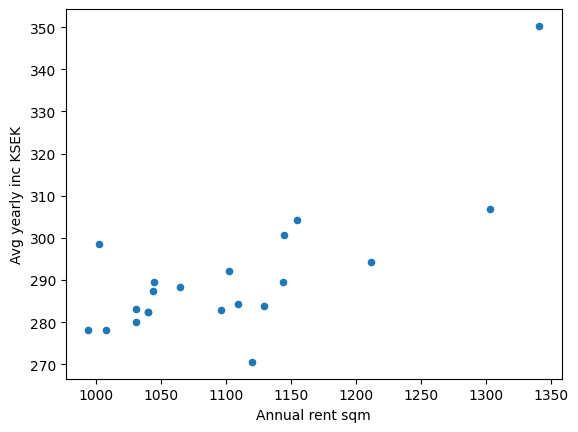

In [307]:
income_vs_rent_data.plot.scatter(x='Annual rent sqm', y='Avg yearly inc KSEK')

## Implement clustering
As mentioned in the introduction section you will create your K-means function from
scratch.
- Initialize the centroids with a starting number of clusters you consider correct, the centroids can be selected as a random point among your sample.
- Find which point belongs to which cluster by finding the closer centroid to every point
(Euclidean distance).
- Calculate the mean point among each cluster to obtain the new centroid
- Repeat this process a N (around 10)  number of iterations until the mean of the new
cluster does not change from the previous iteration.
- Create once again a cluster plot with colors assigned for each cluster. For information on
how to do this plot, check: https://pythonguides.com/matplotlib-scatter-plot-color/

First let's implement a function calculating the euclidean distance

In [308]:
def eucledian_distance(point, array_of_points):
    return np.sqrt(np.sum((point - array_of_points)**2, axis=1))

Now we can implement the k-means algorithm:

In [309]:
from random import randint


def my_kmeans(data, number_of_clusters, distance_measure, max_iterations=10):
    def calculate_closest_points_to_centroid(centroids):
        closest_points_to_centroid = [[] for _ in range(number_of_clusters)]
        for data_point in data:
            closest_centroid_index = np.argmin(distance_measure(data_point, centroids))
            closest_points_to_centroid[closest_centroid_index].append(data_point)
        return closest_points_to_centroid

    def calculate_new_centroids(centroids, closest_points_to_centroid):
        new_centroids = [[] for _ in range(number_of_clusters)]
        for i, cluster_points in enumerate(closest_points_to_centroid):
            if not cluster_points:
                new_centroids[i] = centroids[i]
            else:
                new_centroids[i] = np.mean(cluster_points, axis=0)
        return new_centroids

    random_index = randint(0, data.shape[0]-1)
    centroids = [data[random_index] for _ in range(number_of_clusters)]

    for iteration in range(0, max_iterations):
        closest_points_to_centroid = calculate_closest_points_to_centroid(
            centroids
        )
        new_centroids = calculate_new_centroids(
            centroids, closest_points_to_centroid
        )
        converged = np.all(np.equal(centroids, new_centroids))
        if converged:
            break
        else:
            centroids = new_centroids

    # Cluster assignment
    all_centroids = []
    all_centroid_ixs = []
    for data_point in data:
        centroid_idx = np.argmin(distance_measure(data_point, centroids))
        all_centroids.append(centroids[centroid_idx])
        all_centroid_ixs.append(centroid_idx)

    return all_centroids, all_centroid_ixs

We only need the rent and income columns for the clustering.

In [310]:
income_vs_rent_data_for_clustering = income_vs_rent_data[
    ['Annual rent sqm', 'Avg yearly inc KSEK']
].values.astype(np.float32)

Now we can use our function to perform the k-means clustering. Let's use 3 clusters to begin with.

In [311]:
centroids, assigned_clusters = my_kmeans(
    income_vs_rent_data_for_clustering,
    number_of_clusters=3,
    distance_measure=eucledian_distance,
)
income_vs_rent_data['cluster'] = assigned_clusters

To see if the results are reasonable, let's do a scatter plot again, but this time color the points according to the cluster index.

Text(0, 0.5, 'Avg yearly inc KSEK')

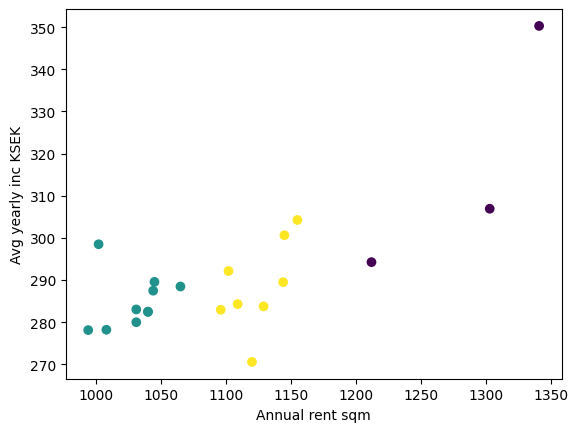

In [312]:
plt.scatter(
    x=income_vs_rent_data['Annual rent sqm'],
    y=income_vs_rent_data['Avg yearly inc KSEK'],
    c=income_vs_rent_data['cluster'],
)
plt.xlabel('Annual rent sqm')
plt.ylabel('Avg yearly inc KSEK')
# Alternatively Seaborn can be used
# sns.lmplot(x='Annual rent sqm', y='Avg yearly inc KSEK', data=income_vs_rent_data, hue='cluster', fit_reg=False)

We can see that the data points have been clustered mostly according to the annual rent per square meter, the average yearly income was largely ieft ignored by the k-means algorithm.